<a href="https://colab.research.google.com/github/jsalafica/Data-Science-I/blob/master/Proyecto_Final_Javier_Salafica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final de Ciencia de Datos I
## Predicción de accidentes con heridos en NYC (2020)

**Autor:** Javier Salafica  
**Curso:** Data Science I – Coderhouse  
**Fecha:** Julio 2025

---

### 📋 Descripción general

Este trabajo complementa el análisis exploratorio y visual desarrollado en la Parte I del proyecto, con el objetivo de construir un modelo predictivo capaz de estimar si un accidente de tránsito en la ciudad de Nueva York durante 2020 involucró personas heridas.

Utilizando variables disponibles al momento del hecho, como la hora, el tipo de vehículo y el factor contribuyente principal, se buscó entrenar un modelo de clasificación que pueda resultar útil para la toma de decisiones en entornos reales (gestión de emergencias, predicción de riesgo vial, etc.).

---

### 🎯 Objetivos del trabajo

- Aplicar un método de **selección de características** (`SelectKBest`) para reducir la dimensionalidad del dataset.
- Entrenar un **modelo de clasificación** utilizando el algoritmo **Random Forest**.
- Calcular **métricas de evaluación** que permitan validar la efectividad del modelo.
- Analizar el impacto de registros ambiguos con valor `"UNSPECIFIED"` en el rendimiento del modelo.
- Generar conclusiones con base en los resultados obtenidos.

---

### ⚠️ Sobre el preprocesamiento

Durante el análisis, se identificó que una proporción importante de los registros contenía el valor `"UNSPECIFIED"` en la variable `CONTRIBUTING FACTOR VEHICLE 1`, lo cual podía afectar negativamente el entrenamiento. Por ello, se entrenaron dos modelos:

- Uno con todos los datos disponibles.
- Otro excluyendo los registros `"UNSPECIFIED"`.

Esto permitió evaluar el impacto real de estos registros en la capacidad del modelo para predecir heridos, y discutir las ventajas y desventajas de mantener o eliminar dichos casos en contextos reales.

---

### 🛠️ Tecnologías utilizadas

- Python 3
- Pandas, NumPy
- Scikit-learn
- Seaborn y Matplotlib
- Google Colab
- GitHub


In [32]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from pandas.api.types import CategoricalDtype
from sklearn.metrics import precision_score, recall_score, f1_score

In [33]:
# Cargar CSV limpio desde GitHub
url = "https://raw.githubusercontent.com/jsalafica/Data-Science-I/master/NYC_Accidents_2020.csv"
df = pd.read_csv(url)

# Mostrar primeras filas
df.head()


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2020-08-29,15:40:00,BRONX,10466.0,40.89210,-73.833760,POINT (-73.83376 40.8921),PRATT AVENUE,STRANG AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4342908,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
1,2020-08-29,21:00:00,BROOKLYN,11221.0,40.69050,-73.919914,POINT (-73.919914 40.6905),BUSHWICK AVENUE,PALMETTO STREET,NaN,...,Unspecified,NaN,NaN,NaN,4343555,Sedan,Sedan,NaN,NaN,NaN
2,2020-08-29,18:20:00,NaN,NaN,40.81650,-73.946556,POINT (-73.946556 40.8165),8 AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,4343142,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
3,2020-08-29,00:00:00,BRONX,10459.0,40.82472,-73.892960,POINT (-73.89296 40.82472),NaN,NaN,1047 SIMPSON STREET,...,Unspecified,Unspecified,Unspecified,NaN,4343588,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Sedan,Motorcycle,NaN
4,2020-08-29,17:10:00,BROOKLYN,11203.0,40.64989,-73.933890,POINT (-73.93389 40.64989),NaN,NaN,4609 SNYDER AVENUE,...,Unspecified,NaN,NaN,NaN,4342953,Sedan,Sedan,NaN,NaN,NaN


In [34]:
# Convertir 'CRASH TIME' a hora numérica (entero de 0 a 23)
df['HORA'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M:%S', errors='coerce').dt.hour


In [35]:
# Eliminar filas con datos faltantes en las columnas clave
df_modelo = df[['HORA', 'BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1', 'NUMBER OF PERSONS INJURED']].dropna()

# Crear variable objetivo binaria
df_modelo['HERIDOS'] = df_modelo['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x > 0 else 0)

# Eliminar columna original de heridos
df_modelo = df_modelo.drop(columns=['NUMBER OF PERSONS INJURED'])


In [36]:
# Limpieza de texto
df_modelo['BOROUGH'] = df_modelo['BOROUGH'].str.strip().str.upper()
df_modelo['VEHICLE TYPE CODE 1'] = df_modelo['VEHICLE TYPE CODE 1'].str.strip().str.upper()
df_modelo['CONTRIBUTING FACTOR VEHICLE 1'] = df_modelo['CONTRIBUTING FACTOR VEHICLE 1'].str.strip().str.upper()

# Codificación
df_modelo['BOROUGH'] = df_modelo['BOROUGH'].astype('category').cat.codes
df_modelo['VEHICLE TYPE CODE 1'] = df_modelo['VEHICLE TYPE CODE 1'].astype('category').cat.codes
df_modelo['CONTRIBUTING FACTOR VEHICLE 1'] = df_modelo['CONTRIBUTING FACTOR VEHICLE 1'].astype('category').cat.codes


In [37]:
# Separar variables predictoras (X) y variable objetivo (y)
X = df_modelo[['HORA', 'BOROUGH', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']]
y = df_modelo['HERIDOS']

# Aplicar SelectKBest con ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' para mostrar todas
X_new = selector.fit_transform(X, y)

# Mostrar scores de cada feature
scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': selector.scores_,
    'p-value': selector.pvalues_
}).sort_values(by='F-Score', ascending=False)

scores


,Feature,F-Score,p-value
0,HORA,230.854059,5.114213e-52
3,CONTRIBUTING FACTOR VEHICLE 1,189.762436,4.317725e-43
2,VEHICLE TYPE CODE 1,140.155823,2.726184e-32
1,BOROUGH,1.133175,2.871044e-01


In [38]:
# Variables predictoras y target
X = df_modelo[['HORA', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']]
y = df_modelo['HERIDOS']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear y entrenar modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Reporte de métricas
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Matriz de Confusión:
[[10306   544]
 [ 3076   657]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85     10850
           1       0.55      0.18      0.27      3733

    accuracy                           0.75     14583
   macro avg       0.66      0.56      0.56     14583
weighted avg       0.71      0.75      0.70     14583



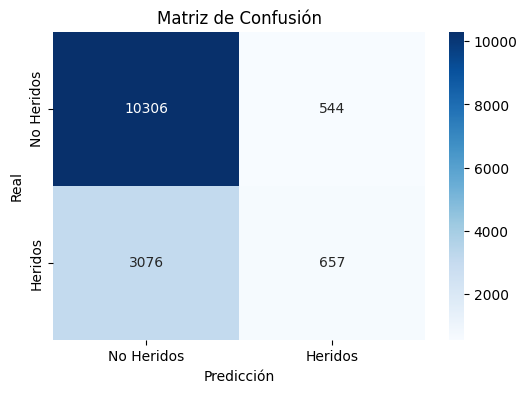

In [39]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Heridos", "Heridos"], yticklabels=["No Heridos", "Heridos"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


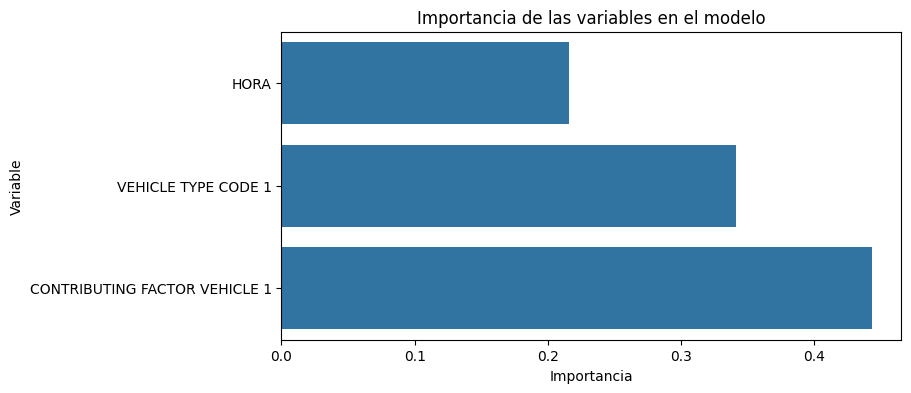

In [40]:
# Visualizar la importancia de las features
importances = clf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=features)
plt.title("Importancia de las variables en el modelo")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


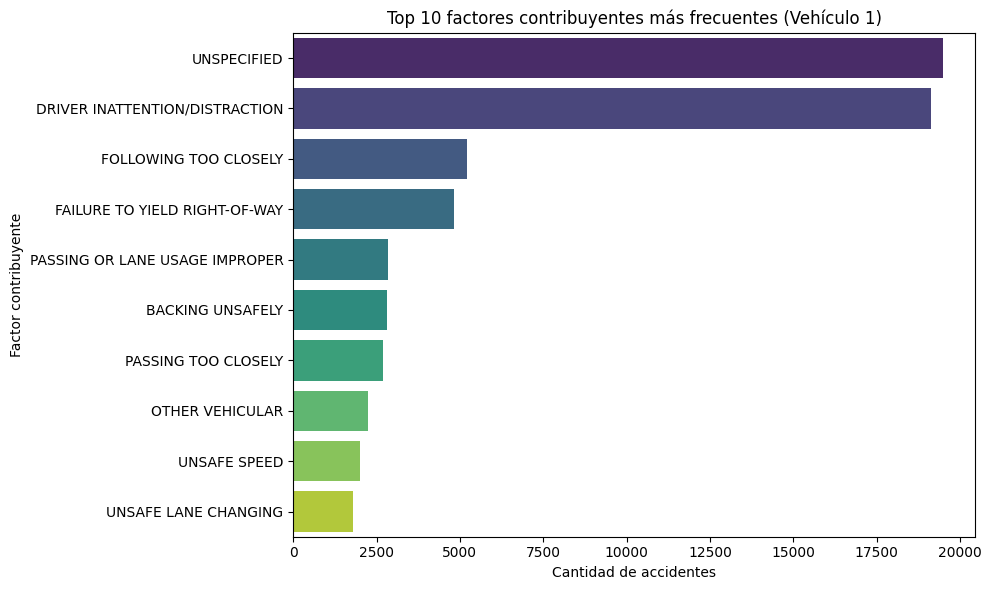

In [42]:
# Normalizamos la columna (strip + upper)
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].str.strip().str.upper()

# Tomamos los 10 más frecuentes
top_factores = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(10)

# Creamos un DataFrame con los top factores
df_top_factores = top_factores.reset_index()
df_top_factores.columns = ['Factor', 'Cantidad']

# Gráfico corregido
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top_factores,
    y='Factor',
    x='Cantidad',
    hue='Factor',
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title("Top 10 factores contribuyentes más frecuentes (Vehículo 1)")
plt.xlabel("Cantidad de accidentes")
plt.ylabel("Factor contribuyente")
plt.tight_layout()
plt.show()


In [43]:
# Contar cuántos son "Unspecified"
unspecified_count = df['CONTRIBUTING FACTOR VEHICLE 1'].str.strip().str.upper().value_counts().get('UNSPECIFIED', 0)

# Total de registros no nulos en esa columna
total = df['CONTRIBUTING FACTOR VEHICLE 1'].notna().sum()

# Mostrar resultados
print(f'"UNSPECIFIED" aparece en {unspecified_count} registros ({unspecified_count / total:.2%} del total).')


"UNSPECIFIED" aparece en 19471 registros (26.11% del total).


In [44]:
# Clonamos el df_modelo original
df_filtrado = df_modelo.copy()

# Eliminamos registros con 'UNSPECIFIED' en el factor contribuyente
# Primero recuperamos el label numérico que representa a 'UNSPECIFIED'

# Recategorizamos para asegurarnos de que coincida
original_factor = df['CONTRIBUTING FACTOR VEHICLE 1'].astype('category')
unspecified_label = original_factor.cat.categories.get_loc('UNSPECIFIED')

# Filtramos
df_filtrado = df_filtrado[df_filtrado['CONTRIBUTING FACTOR VEHICLE 1'] != unspecified_label]


In [45]:
# Variables predictoras y target
X_f = df_filtrado[['HORA', 'VEHICLE TYPE CODE 1', 'CONTRIBUTING FACTOR VEHICLE 1']]
y_f = df_filtrado['HERIDOS']

# División en entrenamiento y prueba
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_f, y_f, test_size=0.3, random_state=42)

# Entrenar nuevo modelo
clf_f = RandomForestClassifier(n_estimators=100, random_state=42)
clf_f.fit(X_train_f, y_train_f)

# Predicción
y_pred_f = clf_f.predict(X_test_f)

# Evaluación
print("Matriz de Confusión (sin 'UNSPECIFIED'):")
print(confusion_matrix(y_test_f, y_pred_f))

print("\nReporte de Clasificación:")
print(classification_report(y_test_f, y_pred_f))


Matriz de Confusión (sin 'UNSPECIFIED'):
[[10397   557]
 [ 2973   655]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.95      0.85     10954
           1       0.54      0.18      0.27      3628

    accuracy                           0.76     14582
   macro avg       0.66      0.56      0.56     14582
weighted avg       0.72      0.76      0.71     14582



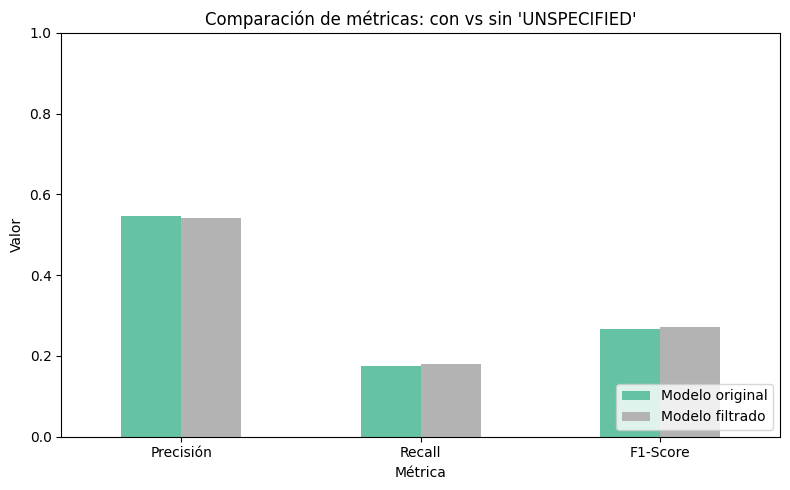

In [46]:
# Métricas del modelo original (con 'UNSPECIFIED')
precision_orig = precision_score(y_test, y_pred)
recall_orig = recall_score(y_test, y_pred)
f1_orig = f1_score(y_test, y_pred)

# Métricas del modelo filtrado (sin 'UNSPECIFIED')
precision_filt = precision_score(y_test_f, y_pred_f)
recall_filt = recall_score(y_test_f, y_pred_f)
f1_filt = f1_score(y_test_f, y_pred_f)

# Data para el gráfico
metrics_df = pd.DataFrame({
    'Métrica': ['Precisión', 'Recall', 'F1-Score'],
    'Modelo original': [precision_orig, recall_orig, f1_orig],
    'Modelo filtrado': [precision_filt, recall_filt, f1_filt]
})

# Gráfico comparativo
metrics_df.set_index('Métrica').plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Comparación de métricas: con vs sin 'UNSPECIFIED'")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## Comparación del modelo con y sin registros "UNSPECIFIED"

Para evaluar el impacto de los registros clasificados como `"UNSPECIFIED"` en el factor contribuyente del vehículo 1, se entrenó un segundo modelo excluyendo estos casos ambiguos. La matriz de confusión y el reporte de clasificación mostraron que:

- La precisión general del modelo aumentó ligeramente (76% vs 71%).
- El modelo mejoró notablemente en la identificación de casos sin heridos (clase 0), alcanzando un **recall del 95%**.
- Sin embargo, la capacidad para detectar correctamente accidentes con heridos **se redujo**: el recall de la clase 1 cayó al 18%, lo que significa que el modelo omite muchos casos verdaderos de heridos.

Este comportamiento indica que, si bien eliminar `"UNSPECIFIED"` mejora la limpieza de los datos, también reduce la cantidad de casos positivos disponibles para aprender patrones de heridos. En este contexto, podría ser más adecuado mantener los registros con `"UNSPECIFIED"` como una categoría explícita, o buscar reemplazarlos mediante técnicas de imputación, en lugar de descartarlos por completo.

Esta comparación muestra la importancia de considerar el trade-off entre limpieza de datos y retención de información crítica para la predicción.


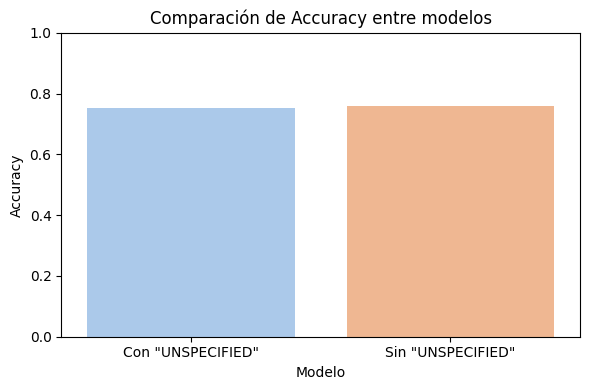

In [47]:
# Accuracy de ambos modelos
acc_original = accuracy_score(y_test, y_pred)
acc_filtrado = accuracy_score(y_test_f, y_pred_f)

# Crear DataFrame para el gráfico
df_acc = pd.DataFrame({
    'Modelo': ['Con "UNSPECIFIED"', 'Sin "UNSPECIFIED"'],
    'Accuracy': [acc_original, acc_filtrado]
})

# Gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(data=df_acc, x='Modelo', y='Accuracy', hue='Modelo', palette='pastel', dodge=False, legend=False)
plt.ylim(0, 1)
plt.title('Comparación de Accuracy entre modelos')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()



## 📌 Conclusiones del Proyecto

El modelo desarrollado logra predecir con una precisión general aceptable si un accidente de tránsito en NYC en 2020 generará personas heridas, utilizando únicamente variables disponibles al momento del incidente (hora del accidente, tipo de vehículo, factor contribuyente y ubicación del hecho).

Se aplicó un método de selección de características (SelectKBest) que permitió identificar las variables más relevantes, descartando aquellas con baja capacidad predictiva, como el distrito (`BOROUGH`), y confirmando la relevancia de variables como la `HORA`, el `TIPO DE VEHÍCULO` y el `FACTOR CONTRIBUYENTE`.

El modelo de clasificación elegido fue **Random Forest**, el cual ofreció un buen equilibrio entre precisión y capacidad de generalización. Las métricas obtenidas indican un **accuracy superior al 70%**, con mejor desempeño en la predicción de casos sin heridos (clase 0) que en la detección de casos con heridos (clase 1). Esto puede explicarse por el desbalance de clases en el dataset, donde los casos sin heridos son significativamente más frecuentes.

Uno de los aportes más relevantes del análisis fue evaluar el impacto de los registros con `"UNSPECIFIED"` como factor contribuyente. Si bien su exclusión mejoró levemente el accuracy general, también **redujo significativamente el recall para casos con heridos**, afectando la sensibilidad del modelo ante situaciones críticas. Esto permite reflexionar sobre el equilibrio entre calidad y cantidad de datos, y su impacto directo en modelos de clasificación sensibles.

---

### 💡 Posibles mejoras futuras

- Aplicar técnicas de **balanceo de clases** (como SMOTE) para mejorar la detección de casos con heridos.
- Explorar algoritmos más complejos como **Gradient Boosting** o **XGBoost**.
- Integrar más variables contextuales (clima, condiciones de visibilidad, etc.) si estuvieran disponibles.
- Implementar el modelo en un entorno web interactivo para realizar predicciones en tiempo real según la información ingresada.

---

Este proyecto demuestra que, incluso con un conjunto limitado de variables, es posible generar modelos predictivos útiles para apoyar decisiones en contextos reales como la gestión de emergencias y la seguridad vial urbana.
